<img style="float: left; margin:0px 20px 20px 0px;" src="https://www.orfeo-toolbox.org/wp-content/uploads/2016/03/logo-orfeo-toolbox.png">

# OTB Guided Tour - JURSE 2019 Vannes France - May 21th
## Yannick TANGUY and David YOUSSEFI (CNES, French Space Agency)
<br>

Orfeo ToolBox (OTB) is an open-source library for remote sensing images processing. It has been initiated and funded by CNES to promote the use and the exploitation of the satellites images. Orfeo ToolBox aims at enabling large images state-of-the-art processing even on limited resources laptops, and is shipped with a set of extensible ready-to-use tools for classical remote sensing tasks, as well as a fully integrated, end-users oriented software called Monteverdi ; OTB is also accessible via Quantum GIS processing module.

This tutorial will present the ORFEO Toolbox and showcase available applications for processing and manipulating satellite imagery.

As a first step, we will learn how to manipulate OTB-Applications through their different interfaces.
Then, we will follow a guided tour of two main processing frameworks (segmentation & classification): we will use data from different sensors (Pléiades or Spot 6/7 with a Sentinel 2 time series) to make a value-added classification map of the region of Rennes (Brittany).


Quicklook by channel


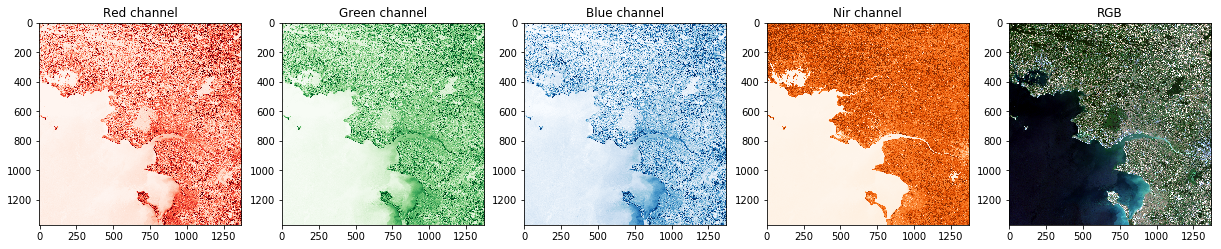

In [32]:
from glob import glob
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# LUT: color_name (string) <-> band (int)
COLORS_BANDS = {'Red':4, 'Green':3, 'Blue':2, 'Nir':8}

# Data directory
DATA_DIR = "data"

# Product information
MGRS = "30TWT"
LEVEL = "L2A"
DATE = "20180805"

# Get Band filename
S2DIR = glob(os.path.join(DATA_DIR, "SENTINEL2?_{0}-*_{1}_T{2}_*".format(DATE, LEVEL, MGRS)))[0]
BAND_FILENAME = os.path.join(S2DIR, os.path.basename(S2DIR) + "_FRE_B%d.tif")

# Normalize bands into 0.0 - 1.0 scale
def normalize(array, quantile=2):
    array_min, array_max = np.percentile(array, quantile), np.percentile(array, 100-quantile)
    normalized = ((array - array_min)/(array_max - array_min))
    normalized[normalized>1] = 1
    normalized[normalized<0] = 0
    return normalized

# Get visible bands from SENTINEL-2 product
s2_prod, rasters, quicklooks = dict(), dict(), dict()
fig, ax = plt.subplots(1,len(COLORS_BANDS)+1, figsize=(21,7))
for nfig, color in enumerate(COLORS_BANDS):
    s2_prod[color] = BAND_FILENAME % COLORS_BANDS[color]
    rasters[color] = rasterio.open(s2_prod[color])
    quicklooks[color] = normalize(rasters[color].read(1, out_shape=(int(rasters[color].height / 8), int(rasters[color].width / 8))))
    try:
        ax[nfig].imshow(quicklooks[color], cmap=color+'s')
    except ValueError:
        ax[nfig].imshow(quicklooks[color], cmap='Oranges')
    ax[nfig].set_title(color+' channel')
        
ax[len(COLORS_BANDS)].imshow(np.dstack((quicklooks['Red'], quicklooks['Green'], quicklooks['Blue'])))
ax[len(COLORS_BANDS)].set_title('RGB')

print ("Quicklook by channel")

In [31]:
from rasterio.warp import transform_bounds
from ipyleaflet import Map, Rectangle, ImageOverlay, FullScreenControl

# Plot footprint on a map

# - get bounding box
epsg4326 = {'init': 'EPSG:4326'}
bounds = transform_bounds(rasters['Red'].crs, epsg4326, *rasters['Red'].bounds)
center = [(bounds[0]+bounds[2])/2, (bounds[1]+bounds[3])/2]

# - get centered map
m = Map(center=(center[-1], center[0]), zoom=7)

# - plot quicklook
quicklook_url = os.path.join(S2DIR, os.path.basename(S2DIR) + "_QKL_ALL.jpg")
quicklook = ImageOverlay(
    url=quicklook_url,
    bounds=((bounds[1], bounds[0]),(bounds[3], bounds[2])),
    name="QUICKLOOK S2A"
)

m.add_layer(quicklook)
m.add_control(LayersControl())
m.add_control(FullScreenControl())

m


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [24]:
from ipyleaflet import DrawControl
draw_control = DrawControl()
m.add_control(draw_control)